# Recurrent Neural Networks
---
# Predicting Stock Prices through an LSTM model

In [1]:
''' Linear Algebra '''
import pandas as pd
import numpy as np

'''Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

In [2]:
''' Hnadling timestamps'''
import datetime
from datetime import datetime

In [3]:
# tech stocks
coin = ['BTC', 'ETH']

In [4]:
# today
end = datetime.now()

In [5]:
start = datetime(2012, 1, 1)
start

datetime.datetime(2012, 1, 1, 0, 0)

In [6]:
url = 'https://raw.githubusercontent.com/timjab92/cryptotradingindicator/master/data/BTCUSD_4hours.csv'

data = pd.read_csv(url)
# Dataset is now stored in a Pandas Dataframe

In [7]:
coin_selection = "BTC"
# coin_data = {"BTC":"BTCUSD_4hours.csv"}

# data = pd.read_csv(data_path + coin_data[coin_selection])

data = data.drop(columns="Unnamed: 0").set_index("date")
data = data[10000:]
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close
date,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318
2016-09-12 04:00:00,605.892222,606.177516,605.676405,605.881569,2.487445,6.406701,6.407171,6.406345,6.406684
2016-09-12 08:00:00,605.702602,606.161735,605.157959,605.682296,5.324050,6.406387,6.407145,6.405488,6.406353
...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660


In [8]:
## add other features

def add_ema(data, tspan=[12,26,20,50,34,55]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data.log_close.ewm(span=t).mean()
    return data

add_ema(data)

def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi



rsi = computeRSI(data)

def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  

stoch_rsi(rsi)

def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data['log_close'], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data

add_stoch_rsi(data)

def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down

prices = data["log_close"]

get_bollinger_bands(prices, rate=20)

def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    return data

add_bollinger(data,prices)

def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

add_vol_roc(data)
data.head(3)

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema50,ema34,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,,,,,,,,,
2016-09-11 16:00:00,622.530173,622.773815,622.393815,622.601965,0.645503,6.433792,6.434183,6.433573,6.433907,6.433907,...,6.433907,6.433907,6.433907,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-11 20:00:00,608.858585,609.295377,608.338821,608.752830,21.064810,6.411376,6.412097,6.410514,6.411200,6.421607,...,6.422326,6.422220,6.422347,NaN,NaN,NaN,NaN,NaN,NaN,31.633193
2016-09-12 00:00:00,604.478168,604.792618,604.236335,604.450576,3.045742,6.404364,6.404884,6.403964,6.404318,6.414859,...,6.416082,6.415898,6.416118,NaN,NaN,NaN,NaN,NaN,NaN,-0.855411


### Daily return

$ return = \frac{new - old}{old} $

In [9]:
data['4h Return'] = data['close'].pct_change()
data['4h Gradient'] = data['close'].diff()

In [10]:
data = data.dropna()

## Time-Series Visualisation

### Historical Stock Prices

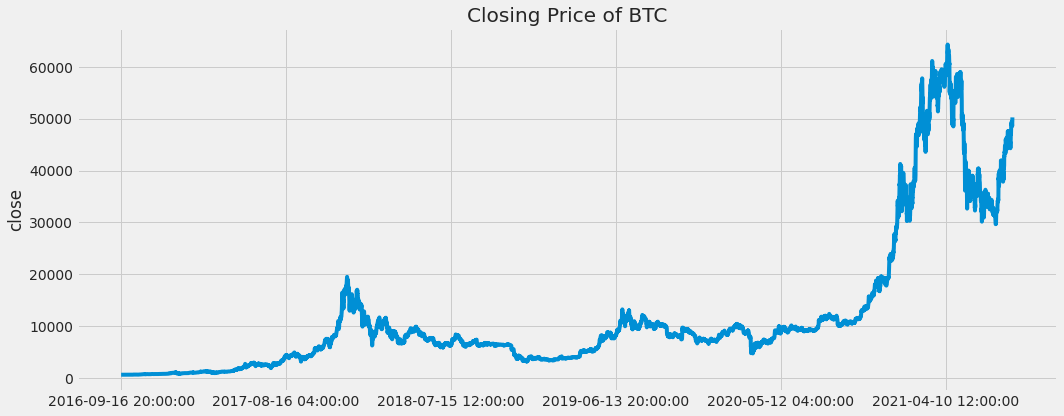

In [11]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['close'].plot()
plt.ylabel('close')
plt.xlabel(None)
plt.title(f"Closing Price of {coin_selection}")
    
plt.tight_layout()

### Volumes traded

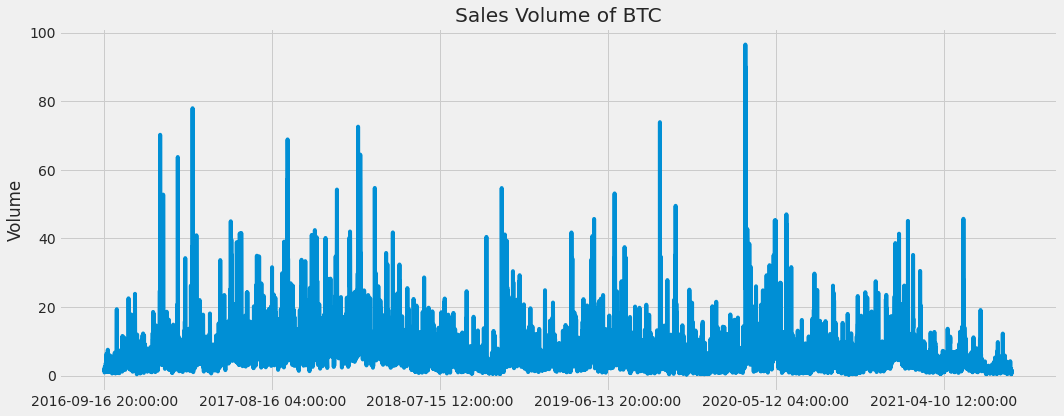

In [12]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 6))
plt.subplots_adjust(top=1.25, bottom=1.2)

data['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"Sales Volume of BTC")
    
plt.tight_layout()

In [13]:
data.head()

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,ema55,rsi,K,D,sma,bollinger_up,bollinger_down,vol_roc,4h Return,4h Gradient
date,,,,,,,,,,,,,,,,,,,,,
2016-09-16 20:00:00,606.420076,606.511450,606.326031,606.412748,2.307185,6.407572,6.407723,6.407417,6.407560,6.408324,...,6.409036,40.074263,66.832576,68.633211,6.409163,6.412655,6.405670,-0.592995,0.001020,0.618162
2016-09-17 00:00:00,606.393333,606.546449,606.200652,606.373841,0.914466,6.407528,6.407780,6.407210,6.407496,6.408196,...,6.408957,39.930892,54.323486,64.618565,6.409170,6.412646,6.405694,-0.603644,-0.000064,-0.038908
2016-09-17 04:00:00,605.275088,605.384737,605.165702,605.290175,0.945083,6.405683,6.405864,6.405502,6.405707,6.407812,...,6.408794,36.082672,52.566827,57.907630,6.408919,6.412637,6.405200,0.033480,-0.001787,-1.083665
2016-09-17 08:00:00,605.660526,605.763263,605.491368,605.612421,1.887662,6.406319,6.406488,6.406039,6.406239,6.407569,...,6.408667,37.996168,47.010486,51.300266,6.408753,6.412644,6.404862,0.997351,0.000532,0.322246
2016-09-17 12:00:00,605.679435,605.831129,605.474355,605.635484,1.246336,6.406350,6.406601,6.406012,6.406278,6.407370,...,6.408550,38.140984,42.224688,47.267334,6.408580,6.412591,6.404568,-0.339746,0.000038,0.023063


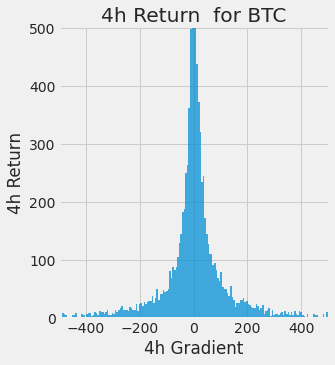

In [14]:
sns.displot(data = data, x= '4h Gradient')
plt.ylabel('4h Return')
plt.xlim([-500,500])
plt.ylim([0,500])
plt.title(f"4h Return  for {coin_selection}");

In [16]:
## get only the close data
selected_features=['log_close', 'ema12', 'ema26', 'ema20', 'ema50', 'ema34',
       'ema55', 'rsi', 'K', 'D', 'bollinger_up', 'bollinger_down',
       'vol_roc']
selected_data = data[selected_features]
selected_data.sample(10)

,log_close,ema12,ema26,ema20,ema50,ema34,ema55,rsi,K,D,bollinger_up,bollinger_down,vol_roc
date,,,,,,,,,,,,,
2018-04-23 16:00:00,9.094809,9.088010,9.068985,9.077401,9.037236,9.057928,9.031383,70.378295,22.979578,16.638580,9.115075,9.049816,-0.261508
2016-09-17 00:00:00,6.407496,6.408196,6.408667,6.408525,6.408929,6.408790,6.408957,39.930892,54.323486,64.618565,6.412646,6.405694,-0.603644
2017-08-12 20:00:00,8.251182,8.200991,8.163578,8.177827,8.114441,8.146086,8.105395,85.461453,98.709486,98.709486,8.259637,8.067355,-0.216079
2016-11-06 20:00:00,6.559667,6.558615,6.559975,6.559651,6.554323,6.559156,6.552308,49.802115,68.930627,78.918340,6.569065,6.537946,-0.353062
2021-07-17 16:00:00,10.365560,10.364932,10.375899,10.371213,10.390602,10.381528,10.392955,43.623780,78.477636,64.988367,10.404146,10.339935,-0.040408
2019-06-15 04:00:00,9.066868,9.032151,9.012563,9.019116,9.001382,9.006804,9.000550,82.194987,100.000000,100.000000,9.063960,8.963040,-0.362987
2016-12-03 12:00:00,6.636180,6.633877,6.623569,6.627545,6.613959,6.619491,6.612620,63.483210,12.148357,34.292735,6.656969,6.596060,1.017430
2018-07-30 12:00:00,9.004336,9.008307,9.003270,9.006323,8.982248,8.997435,8.977108,51.449379,5.104738,9.255110,9.028090,8.984838,-0.675386
2018-05-08 00:00:00,9.144499,9.153399,9.157115,9.157184,9.148872,9.155293,9.146374,41.906614,14.259374,9.232663,9.213518,9.124423,0.918972


## Apple Stock Price

### Temporal Train-Test Split

In [17]:
train_percentage = 95

In [18]:
train_len = int(len(selected_data) * train_percentage/100)
train_len

10268

In [19]:
data_train = selected_data[:train_len]
data_test = selected_data[train_len:]


## LSTM

In [20]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler(feature_range = (0,1))

minmax_scaler.fit(data_train)

data_train_scaled = minmax_scaler.transform(data_train)
data_test_scaled = minmax_scaler.transform(data_test)

In [21]:
minmax_scaler.data_max_

array([ 11.07190746,  11.04918197,  11.0369933 ,  11.04254271,
        11.02171487,  11.03017891,  11.01920724,  96.22920799,
       100.        , 100.        ,  11.10194656,  11.0213134 ,
        20.81970308])

In [22]:
minmax_scaler.data_min_

array([ 6.38719526,  6.39041998,  6.3947412 ,  6.39310696,  6.39767259,
        6.39639054,  6.39800528,  4.35903634,  0.        ,  0.        ,
        6.39923547,  6.3762964 , -0.9157509 ])

In [23]:
min1 = minmax_scaler.data_min_[0]
min1

6.387195256273513

In [24]:
range1 = minmax_scaler.data_range_[0]
range1

4.684712203487527

### Creating subsequences...

In [25]:
window_size = 18 # test with small window size
horizon = 1 #number of predictions into the future :) 
data_train_subsequences = []
fake_y_train = []
for k in range(len(data_train_scaled)-(window_size-1)-horizon):
    data_train_subsequences.append(data_train_scaled[k:k+window_size])
    fake_y_train.append(data_train_scaled[k+window_size])

In [26]:
X_train = np.array(data_train_subsequences)
y_train = np.array(fake_y_train)[:,0].reshape(-1,1)

In [27]:
X_train.shape

(10250, 18, 13)

In [28]:
y_train.shape

(10250, 1)

In [29]:
#with the same window_size & horizon as the train data
window_size = 18
horizon = 1
data_test_subsequences = []
fake_y_test = []
for k in range(len(data_test_scaled)-(window_size-1)-horizon):
    data_test_subsequences.append(data_test_scaled[k:k+window_size])
    fake_y_test.append(data_test_scaled[k+window_size])

In [30]:
X_test = np.array(data_test_subsequences)
y_test = np.array(fake_y_test)[:,0].reshape(-1,1)

In [31]:
X_test.shape

(523, 18, 13)

In [32]:
y_test.shape

(523, 1)

### LSTM

#### RNN Architecture

In [33]:
pd.DataFrame(y_test).shape

(523, 1)

In [34]:
from tensorflow.keras import metrics

my_mae = metrics.MeanAbsoluteError(
    name='mean_absolute_error', dtype=None
)


2021-08-27 16:42:05.421741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-27 16:42:05.421784: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-27 16:42:06.355929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-27 16:42:06.355965: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-27 16:42:06.355993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-33CGF2OU): /proc/driver/nvidia/version does not exist
2021-08-27 16:42:06.356169: I tensorflow/core/platform/cpu_fe

In [36]:
from tensorflow.keras import Sequential, layers

# Build the LSTM model
model = Sequential()

model.add(layers.LSTM(units=128,
                     return_sequences = True,
                     activation = "tanh"
                    #activation = "relu"
                     #input_shape = X_train[0].shape)
                     ))

model.add(layers.LSTM(units=64,
                      return_sequences = False,
                      activation = "relu"  
                    #activation = "relu"
                     ))

# model.add(layers.Dense(25,
#                          activation="relu"))
model.add(layers.Dense(32,
                        activation = "tanh" 
                       #activation="relu"
                      ))
#model.add(layers.Dense(16,activation="relu"))
model.add(layers.Dense(8,
                       activation = "relu"
                       #activation="relu"
                      ))
model.add(layers.Dense(1,
                      activation = "relu" 
                      #activation="relu"
                      ))

#model.summary()



In [37]:
model.compile(loss="mse",
             optimizer = "adam",#rmsprop
             metrics = "mae"#[my_mae]
             )

#### Training

In [38]:
#### perhaps create a validation and train sets by hand

In [39]:
# from tensorflow.keras.callbacks import EarlyStopping 

# es = EarlyStopping(#patience = 5, 
#                    restore_best_weights=
#                    #monitor = "val_mean_absolute_error"
#                   )

history = model.fit(X_train, y_train,
          validation_split = 0.3,
         batch_size=16,
         epochs=5,
         verbose = 1,
         #callbacks = [es]
                   )

2021-08-27 16:43:24.696568: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
449/449 [==============================] - 9s 16ms/step - loss: 9.9349e-04 - mae: 0.0115 - val_loss: 3.4944e-04 - val_mae: 0.0130
Epoch 2/5
449/449 [==============================] - 6s 14ms/step - loss: 6.6613e-05 - mae: 0.0061 - val_loss: 8.8755e-04 - val_mae: 0.0239
Epoch 3/5
449/449 [==============================] - 6s 14ms/step - loss: 5.7270e-05 - mae: 0.0057 - val_loss: 1.9251e-04 - val_mae: 0.0103
Epoch 4/5
449/449 [==============================] - 7s 15ms/step - loss: 6.3796e-05 - mae: 0.0060 - val_loss: 2.3745e-04 - val_mae: 0.0104
Epoch 5/5
449/449 [==============================] - 7s 15ms/step - loss: 6.8861e-05 - mae: 0.0064 - val_loss: 4.5495e-04 - val_mae: 0.0158


In [40]:
def plot_loss_mae(history):
    
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
#     # --- MAE

#     ax[1].plot(history.history['mean_absolute_error'])
#     ax[1].plot(history.history['val_mean_absolute_error'])
#     ax[1].set_title('Model MAE', fontsize = 18)
#     ax[1].set_xlabel('Epoch', fontsize = 14)
#     ax[1].set_ylabel('Recall', fontsize = 14)
#     ax[1].legend(['Train', 'Val'], loc='lower right') 
#     ax[1].grid(axis="x",linewidth=0.5)
#     ax[1].grid(axis="y",linewidth=0.5)   
    
    plt.show()
    

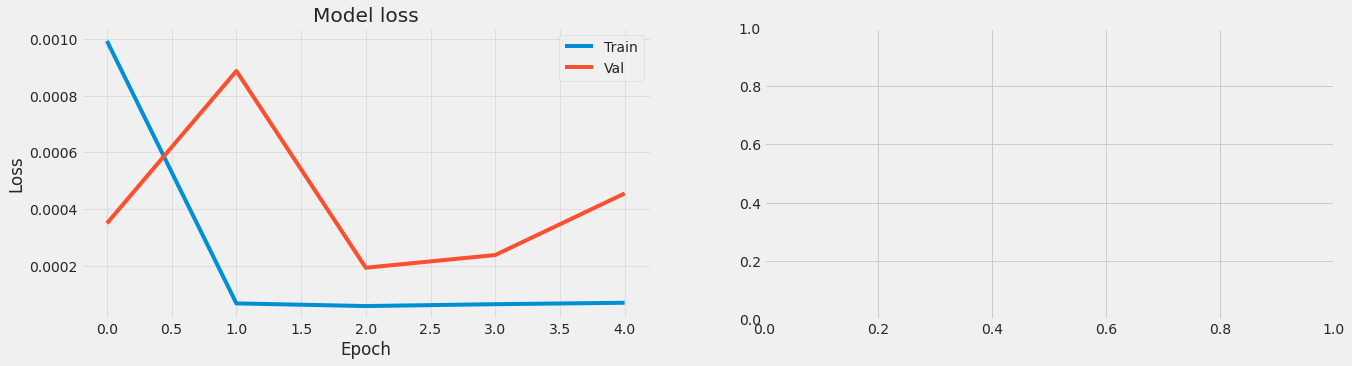

In [41]:
plot_loss_mae(history)

#### Evaluating

In [42]:
res = model.evaluate(X_test, np.array(y_test), verbose = 1)
res


17/17 [==============================] - 0s 6ms/step - loss: 8.8291e-04 - mae: 0.0288


[0.0008829053258523345, 0.02877512387931347]

#### Predictions

In [43]:
predictions = model.predict(X_test)


In [44]:
len(predictions), len(y_test)

(523, 523)

In [45]:
predictions[0:3]

array([[0.86476594],
       [0.8595936 ],
       [0.8547139 ]], dtype=float32)

In [46]:
y_test_unscaled = y_test * range1 + min1

In [47]:
predictions_unscaled = predictions * range1 + min1

In [50]:
predictions_unscaled[0:3]

array([[10.438375],
       [10.414144],
       [10.391284]], dtype=float32)

The operation computed during a `MinMaxScaler` Operation is:

$$x_{scaled} = \frac{x - x_{min}}{x_{max}- x_{min}}$$

To descale it:

$$x = x_{scaled} * (x_{max}- x_{min}) + x_{min}$$

Or use the `inverse_transform` directly provided...

In [51]:
np.mean(np.abs(y_test_unscaled - predictions_unscaled))

0.13480317091876343

# PREDICTION WITH COINGECKO!!!

In [55]:
import requests

def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api

def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data.log_close)
    add_vol_roc(data)
    return data

In [60]:
coingecko = feature_engineer(get_coingecko())[-60:]
x_gecko = coingecko[selected_features]
x_gecko_scaled = minmax_scaler.transform(x_gecko)

In [61]:
x_gecko.shape

(60, 13)

In [63]:
x_gecko = np.array(x_gecko_scaled)
x_gecko = np.reshape(x_gecko, (1,60,13))

x_gecko.shape

(1, 60, 13)

In [64]:
predictions = model.predict(x_gecko)

predictions[0]

array([0.8975706], dtype=float32)

In [66]:
predictions_unscaled = predictions * range1 + min1

In [ ]:

predictions

weight

np.exp(predictions)


## Second round

In [48]:
weg ergwrwr g

SyntaxError: invalid syntax (864225811.py, line 1)

In [ ]:
dataset = data[["close"]].values
dataset

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

In [ ]:
length = 60
horizon  = 1

training_split = 0.85
training_data_length = int(np.ceil(len(dataset) * training_split))
training_data_length

In [ ]:
# Create the training data set 
# Create the scaled training data set

train_data = scaled_data[0:int(training_data_length), :]
# Split the data into x_train and y_train data sets
y_train = []

x_train = [train_data[i-length:i, 0] for i in range(length, len(train_data))]
y_train = [train_data[i, 0] for i in range(length, len(train_data))]
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [ ]:
# Create the testing data set
# Create a new array containing scaled values from index 543 to 2002 
test_data = scaled_data[training_data_length - length: , :]
# Create the data sets x_test and y_test

y_test = dataset[training_data_length:, :]
x_test = [test_data[i-length:i, 0] for i in range(length, len(test_data))]
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics = my_mae)

# Train the model
history = model.fit(x_train, y_train, batch_size=8, epochs=5, validation_split = 0.4)

In [ ]:
plot_loss_mae(history)

In [ ]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions[:3]

In [ ]:
y_test.shape, predictions.shape

In [ ]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
# Plot the data
train = selected_data[:training_data_length]
valid = selected_data[training_data_length:].copy()

In [ ]:
train

In [ ]:
valid

In [ ]:
valid["Predictions"] = predictions
valid

In [ ]:
valid.index = pd.to_datetime(valid.index, format = "%Y-%m-%d %H:%M:%S")
train.index = pd.to_datetime(train.index, format = "%Y-%m-%d %H:%M:%S")

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.xlim([datetime.date(2020, 1, 1), datetime.datetime.now()])
plt.show()